don't go here! often

========================Iteration 0 =======================
	 time: 1.51186108589

========================Iteration 1 =======================
	 time: 1.67734098434

========================Iteration 2 =======================
	 time: 1.70774388313

========================Iteration 3 =======================
	 time: 1.72356295586

========================Iteration 4 =======================
	 time: 1.7333791256

========================Iteration 5 =======================
	 time: 1.76170611382
	HP Optimization:
		before: width= 1 - amp= 2 - noise= 1
		after: width= 0.373259275456 - amp= 2.66337611696 - noise= 0.256642089872

========================Iteration 6 =======================
	 time: 1.98300099373
	HP Optimization:
		before: width= 0.373259275456 - amp= 2.66337611696 - noise= 0.256642089872
		after: width= 0.363609625965 - amp= 2.50761911886 - noise= 0.257957540182

========================Iteration 7 =======================
	 time: 2.05121302605
	HP Optimiza

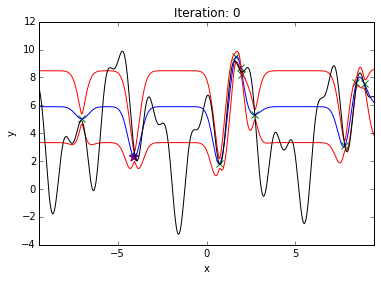

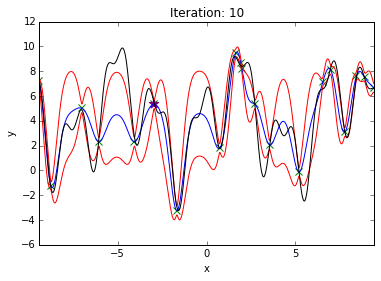

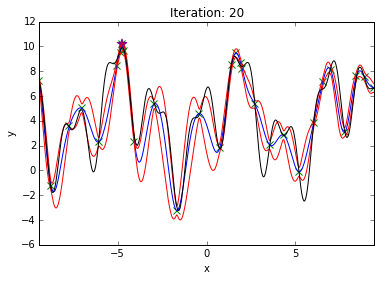

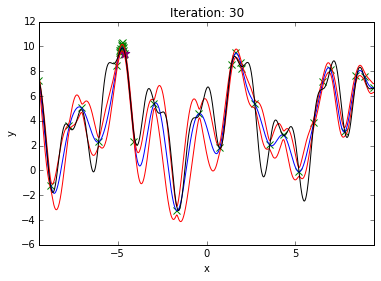

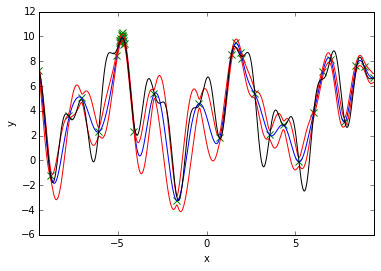

In [7]:
import gaussian_process, covariance_functions, acquisition_functions, bayesian_optimization, sys, datasets
import numpy as np
import matplotlib.pyplot as p
from scipy.stats import multivariate_normal
%matplotlib inline


class ACQUI(object):
    def __init__(self, X_range, acqui_fun, mode, thres, lastSize=10, goal_shape=(0,0), space_mask=None):
        self.x_range = X_range
        self.fun = acqui_fun
        self.mode = mode
        self.i =0
        if mode == 'last':
            #get_last params
            self.thres = thres
            self.last = np.empty(shape=(0,self.x_range.shape[1]))
            self.lastSize = lastSize
        
        elif mode == 'prob':
            #get_prob params
            self.goal_shape = goal_shape
            self.space_mask = np.ones(shape=self.goal_shape, dtype='bool')
            if space_mask is not None:
                self.space_mask = space_mask
            self.space = np.ones(shape=self.goal_shape, order='C')
            self.space[~self.space_mask] = np.nan
            self.thres = np.ceil(thres / 2 * (np.abs(X_range[1,0] - X_range[0, 0])))

            #update_matrix
            x = np.arange(-self.thres, self.thres + 1)
            x, y = np.meshgrid(x,x)
            pos = np.dstack((x, y))
            fct = multivariate_normal([0,0], [[self.thres, 0], [0, self.thres]])
            self.update_matrix = fct.pdf(pos)
            self.update_matrix /= self.update_matrix[self.thres, self.thres]
        
    def get(self):        
        if self.mode == 'last': return self.get_last
        elif self.mode == 'prob': return self.get_prob
        else: return None
        
    def get_last(self, x, gp, **dict): 
        #call acqui function
        res = self.fun(x, gp, **dict) 
        if dict and dict['prt']:
            return res
        
        #block indices and nearbyes from the last lastSize rounds
        for i in self.last:
            mask = np.linalg.norm(self.x_range - i, axis=1)
            res[mask < self.thres] = 0
       
        #find index of max value
        idx_2d = np.where(res == res[np.argmax(res)])
        idx_1d = np.random.choice(len(idx_2d[0]), 1, replace=False)
        idx_1d = idx_2d[0][idx_1d][0]

        #update params
        if len(self.last) == self.lastSize:
            self.last = np.delete(self.last, 0, axis=0)
        self.last = np.concatenate((self.last, self.x_range[idx_1d, :][np.newaxis,:]), axis=0)

        res = np.zeros(shape=res.shape)
        res[idx_1d, :] = 1
        return res
    
    def get_prob(self, x, gp, **dict):        
        #call acqui function
        res = self.fun(x, gp, **dict) 
        if dict and dict['prt']:
            return res
        
        #apply weights
        res = np.multiply(res.T, 1 - self.space[self.space_mask].flatten()).reshape(res.shape)
        
        """plot new distribution
        tmp = np.zeros(self.goal_shape)
        tmp[self.space_mask] = res.ravel()
        p.contourf(X, Y, tmp)
        p.colorbar()
        p.show()"""
        
        #find index of max value
        idx_2d = np.where(res == res[np.argmax(res)])
        idx_1d = np.random.choice(idx_2d[0], 1, replace=False)[0]
        
        res = np.zeros(shape=res.shape)
        res[idx_1d, :] = 1
        
        tmp = np.zeros(self.goal_shape)
        tmp[self.space_mask] = res.ravel()
        idx_2d = np.unravel_index(tmp.argmax(), tmp.shape)
        
        #find weights to update
        xwindow = np.arange(idx_2d[0] - self.thres, idx_2d[0] + self.thres + 1)
        ywindow = np.arange(idx_2d[1] - self.thres, idx_2d[1] + self.thres + 1)  
        ymask = (ywindow >= 0) & (ywindow < self.goal_shape[1])
        xmask = (xwindow >= 0) & (xwindow < self.goal_shape[0])
        
        xwindow, ywindow = np.meshgrid(xwindow[xmask], ywindow[ymask])
        xmask, ymask = np.meshgrid(xmask, ymask)
        mask = np.array((xmask & ymask), dtype=bool)
        
        #update params
        x_shape = np.sum(mask[:, np.amax(np.argmax(mask, axis=1))])
        y_shape = np.sum(mask[np.amax(np.argmax(mask, axis=0)), :])
        update_matrix_shape = (x_shape, y_shape)
        self.space[xwindow.astype(int), ywindow.astype(int)] += self.update_matrix[mask].reshape((update_matrix_shape))  
        self.space /= np.nanmax(self.space)
        
        return res 
    
#parameters gaussian process
dimensions = 1
noise = 1
cov_func = covariance_functions.gaussian_kernel
cov_grad = covariance_functions.gaussian_kernel_gradient
width = 1
amp = 2
params = [width, amp]

#initialize gaussian process
gp = gaussian_process.GP_Regressor(dimensions, noise, cov_func, cov_grad, params)

#parameters bayesian optimization
iterations = 40
X_range = np.arange(-3*np.pi, 3*np.pi, 0.01)[:,np.newaxis]
goal_func = (lambda x: 5 + 3*datasets.toy_func(x) + np.random.normal(0,0.2, size=x.shape)) #lambda x: datasets.toy_func(x) + np.random.normal(0,0.5)#
aa = acquisition_functions.ACQUI(X_range, acquisition_functions.get_function("UCB", 2), mode='prob', thres=1.5, goal_shape=X_range.shape)
acqui_func = aa.get()
#maybe have something like this

#execute bayesian optimization
#gp = bayesian_optimization.bayesian_optimization(gp, iterations, goal_func, acqui_func, X_range)
bounds = [(None, None), (None, None), (0.00001, None)]
save_every = 10
gp, gp_list, s_list, hp_list = bayesian_optimization.bayesian_optimization(gp, iterations, goal_func, 
                                                                  acqui_func, X_range, bounds, save_every=save_every)


for i in range(len(gp_list)):

    gpi = gp_list[i]
    X_new, Y_new = s_list[i]
    mean,cov = gpi.predict(X_range)
    var = cov.diagonal()[:,np.newaxis]
    p.title("Iteration: " + str(i*save_every))
    p.xlabel('x')
    p.ylabel('y')
    p.scatter(gpi.Xtrain,gpi.Ytrain_original,color='green',marker='x', s=50) # training data
    p.plot(X_range,mean,color='blue')                  # GP mean
    p.plot(X_range,mean+var**.5,color='red')           # GP mean + std
    p.plot(X_range,mean-var**.5,color='red')           # GP mean - std
    p.plot(X_range, 5 + 3*datasets.toy_func(X_range),color='black')           # GP mean - std
    p.scatter(X_new,Y_new,color='purple',marker='*', s=100)   # test data
    p.xlim(-3*np.pi,3*np.pi)
    p.show()

    
mean,cov = gp.predict(X_range)
var = cov.diagonal()[:,np.newaxis]
# Plot the data

#p.title("Iteration: " + str(i))
p.xlabel('x')
p.ylabel('y')
p.scatter(gp.Xtrain,gp.Ytrain_original,color='green',marker='x', s=50) # training data
p.plot(X_range,mean,color='blue')                  # GP mean
p.plot(X_range,mean+var**.5,color='red')           # GP mean + std
p.plot(X_range,mean-var**.5,color='red')           # GP mean - std
p.plot(X_range, 5 + 3*datasets.toy_func(X_range),color='black')           # GP mean - std
#p.scatter(X_new,Y_new,color='purple',marker='*', s=100)   # test data
p.xlim(-3*np.pi,3*np.pi)
p.show()